# Load data

In [39]:
from datasets import load_dataset
import os

data_path = "../data/elaborations"

data_files_c2s = {
    'train': os.path.join(data_path,"train","train_ds_c2s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2s.csv")         
}

data_files_c2s_masked = {
    'train': os.path.join(data_path,"train","train_ds_c2s_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2s_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2s_masked_llama.csv")         
}

data_files_c2sp = {
    'train': os.path.join(data_path,"train","train_ds_c2sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2sp.csv")         
}

data_files_c2sp_masked = {
    'train': os.path.join(data_path,"train","train_ds_c2sp_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2sp_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2sp_masked_llama.csv")         
}

data_files_c4s = {
    'train': os.path.join(data_path,"train","train_ds_c4s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4s.csv")         
}

data_files_c4s_masked = {
    'train': os.path.join(data_path,"train","train_ds_c4s_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4s_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4s_masked_llama.csv")         
}


data_files_c2os = {
    'train': os.path.join(data_path,"train","train_ds_c2os.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2os.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2os.csv")         
}

data_files_c2osp = {
    'train': os.path.join(data_path,"train","train_ds_c2osp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2osp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2osp.csv")         
}

data_files_c4sp = {
    'train': os.path.join(data_path,"train","train_ds_c4sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4sp.csv")         
}

data_files_c4sp_masked = {
    'train': os.path.join(data_path,"train","train_ds_c4sp_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4sp_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4sp_masked_llama.csv")         
}

data_files_c4osp = {
    'train': os.path.join(data_path,"train","train_ds_c4osp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4osp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4osp.csv")         
}

dataset = load_dataset('csv', data_files=data_files_c4s_masked)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 1049
    })
    validation: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 134
    })
    test: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 116
    })
})


In [2]:
!nvidia-smi

Tue Nov 26 13:17:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100                    On  | 00000000:64:00.0 Off |                    0 |
| N/A   25C    P0              73W / 699W |      4MiB / 95830MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Check length

In [40]:
def count_texts_over_word_limit(dataset_dict, column, word_limit=150):
    word_count = {}

    for split in dataset_dict:
        dataset = dataset_dict[split]
        count_over_limit = 0

        for example in dataset:
            try:
                num_words = len(example[column].split()) # count on spaces
                if num_words > word_limit:
                    count_over_limit += 1
            except AttributeError as e: 
                print(f"Empty string in doc num: {example['doc_num']}")
                continue 

        word_count[split] = count_over_limit

    return word_count

count_texts_over_word_limit(dataset, column='source_text')

{'train': 0, 'validation': 0, 'test': 0}

# Load the model

In [41]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from trl import setup_chat_format
from trl.extras.dataset_formatting import conversations_formatting_function
# LLAMA 3.2 3B
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-3B', cache_dir="../models/llama/") 
model =  AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.2-3B', cache_dir="../models/llama/", device_map ={'':torch.cuda.current_device()})

model, tokenizer = setup_chat_format(model, tokenizer)
formatting_func = conversations_formatting_function(tokenizer, "messages")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Config

In [3]:
# set the pad_token for llama 3.2 3B
tokenizer.pad_token = tokenizer.eos_token #"<|finetune_right_pad_id|>" 

# Tokenize dataset

In [4]:
import numpy as np

def adjust_labels(example):
    # replace padding token in labels with -100 for correct loss calculation
    example["labels"] = [
        -100 if token == tokenizer.pad_token_id else token
        for token in example["labels"]
    ]
    return example

def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['source_text'], truncation=True, padding="max_length",max_length=64) # padding="max_length"
    # labels
    labels = tokenizer(examples['elaboration_sentence'],truncation=True,padding="max_length", max_length=64)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids'] #labels['input_ids'] or np.array(labels['input_ids'])
    return inputs

tokenized_dataset = dataset.map(tokenize_func, batched=True)
#tokenized_dataset = tokenized_dataset.map(adjust_labels, batched=False)
#tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Fine-tune

In [3]:
from model_utils import calculate_logging_steps
steps_per_epoch, logging_steps = calculate_logging_steps(dataset, batch_size=32, logging_frequency=6)

Steps per epoch: 32
Logging steps: 5


## No instruct

In [6]:
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForLanguageModeling


model.train()

# data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False,  # no masked language modeling 
)

logs_dir = "../models/llama/llama3.2-news-ft/logs/logs-c2s"

training_args = SFTConfig(
    output_dir="../models/llama/llama3.2-news-ft/results/results-c2s",
    max_seq_length= 64,
    eval_strategy="epoch",  
    save_strategy="no",  
    logging_strategy="steps",  
    logging_steps=6, 
    learning_rate=1e-6,  
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    num_train_epochs=3,  
    weight_decay=0.01,  
    warmup_steps=2,  
    optim="paged_adamw_8bit",  
    fp16=True,  
    logging_dir=logs_dir, 
    push_to_hub=False,
    group_by_length=True,  
    save_total_limit=0,

)

trainer = SFTTrainer(
    model,
    train_dataset=tokenized_dataset["train"],  
    eval_dataset=tokenized_dataset["validation"],  
    args=training_args,   
    data_collator=data_collator, 
)

model.config.use_cache = False

In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.960200,3.143848
2,2.700500,3.052567
3,2.559600,3.032315


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=99, training_loss=2.8347623805807096, metrics={'train_runtime': 30.1256, 'train_samples_per_second': 104.164, 'train_steps_per_second': 3.286, 'total_flos': 3396568057380864.0, 'train_loss': 2.8347623805807096, 'epoch': 3.0})

### Learning curve

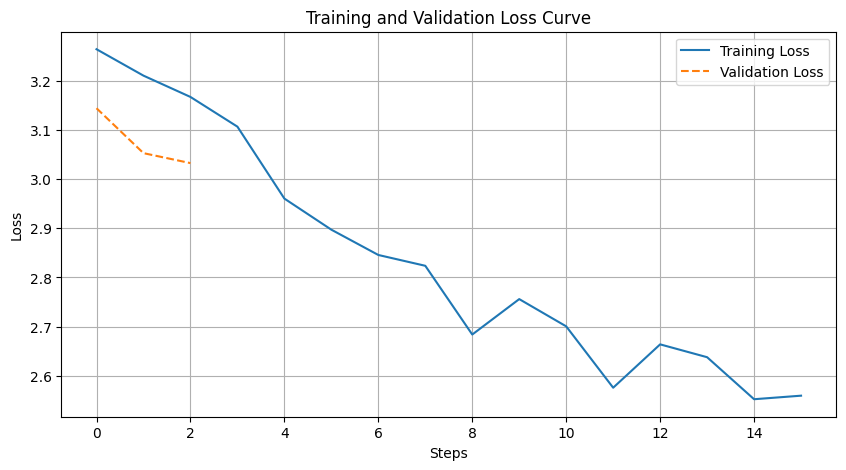

In [8]:
from model_utils import plot_loss_curves
plot_loss_curves(trainer)

## Instruct

https://huggingface.co/docs/trl/en/sft_trainer

### Format dataset with instruction

In [ ]:
# Return your answer in the following format:
#"Explanation sentence": <explanatory sentence text>

In [5]:
ZERO_SHOT_SYSTEM_PROMPT = """You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.
You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.
The tone should be plain and simple!
Return only ONE short concise explanatory sentence!
"""

In [42]:
SYSTEM_PROMPT_MASKED = """You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.
You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.
Your task is to replace the `<explanatory sentence>` tag in the provided text with the explanation sentence you generate.
Return only the explanation sentence itself, without any tags, formatting, or additional text.
The tone should be plain and simple!
Return only ONE short concise explanatory sentence!
"""

In [6]:
SYSTEM_PROMPT_SHORT = """You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
The tone should be plain and simple! Return only ONE short concise explanatory sentence!"""

In [43]:
def format_example(example):
    return {
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT_MASKED},
            {"role": "user", "content": f"{example['source_text']}"}, # Context or Text
            {"role": "assistant", "content":  f"{example['elaboration_sentence']}"}
        ]
    }

def format_test_example(example):
    return {
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT_MASKED},
            {"role": "user", "content": f"{example['source_text']}"},
            {"role": "assistant", "content":  ""}
        ]
    }

formatted_train_dataset = dataset["train"].map(format_example)
formatted_validation_dataset = dataset["validation"].map(format_example)
formatted_test_dataset = dataset["test"].map(format_test_example)

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

In [44]:
formatted_test_dataset[0]["messages"]

[{'content': 'You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. \nYour task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.\nYou may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.\nYour task is to replace the `<explanatory sentence>` tag in the provided text with the explanation sentence you generate.\nReturn only the explanation sentence itself, without any tags, formatting, or additional text.\nThe tone should be plain and simple!\nReturn only ONE short concise explanatory sentence!\n',
  'role': 'system'},
 {'content': 'They did not need special skills or a college education to work there. Those factories are gone now. New companies have come t

In [7]:
def calculate_mean_message_length(dataset):
    total_length = 0
    message_count = 0

    for entry in dataset:
        messages = entry.get('messages', [])
        for message in messages:
            content = message.get('content', "")
            total_length += len(content.split())  # Count words in the content
            message_count += 1

    return total_length / message_count if message_count > 0 else 0

mean_length = calculate_mean_message_length(formatted_train_dataset)
print(f"Mean length of messages: {mean_length}")

Mean length of messages: 60.243724181760406


In [10]:
def formatting_prompts_func(split):
    output_texts = []
    for i in range(len(split)):
        text = f"### Context: {split['source_text'][i]}\n ### Explanation sentence: {split['elaboration_sentence'][i]}"
        output_texts.append(text)
    return output_texts

#formatted_dataset = dataset["train"].map(formatting_prompts_func)

formatting_prompts_func(dataset["train"])[:2]

["### Context: A watermark is an image that can be seen in the paper when you hold it up to the light. Investigators say Kellogg tried to copy the watermark.\n ### Explanation sentence: Here's how they say he did it.",
 '### Context: He called the talk a "fireside hangout." President Franklin D. Roosevelt used to make informal radio broadcasts called "fireside chats."\n ### Explanation sentence: Obama\'s fireside hangout included many questions from different kinds of people.']

#### DataCollatorForCompletionOnlyLM

In [ ]:
from trl import DataCollatorForCompletionOnlyLM

data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer,
    mlm=False, 
    response_template= ...
)

In [45]:
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForLanguageModeling

import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"


model.train()

# data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False,  # no masked language modeling 
)

logs_dir = "../models/llama3.2-news-ft/logs/logs-c4s-masked"

training_args = SFTConfig(
    output_dir="../models/llama3.2-news-ft/results/tmp",
    max_seq_length= 150,
    eval_strategy="epoch",  
    save_strategy="no",  
    logging_strategy="steps",  
    logging_steps=6, 
    learning_rate=1e-6,  
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    #gradient_accumulation_steps=2,
    num_train_epochs=3,  
    weight_decay=0.01,  
    warmup_steps=2,    
    optim="paged_adamw_8bit",  
    fp16=True,  
    logging_dir=logs_dir, 
    push_to_hub=False,
    group_by_length=True,  
    save_total_limit=0,
    #load_best_model_at_end=True, 
    #metric_for_best_model="eval_loss"

)

trainer = SFTTrainer(
    model,
    train_dataset= formatted_train_dataset ,
    eval_dataset= formatted_validation_dataset ,
    args=training_args,   
    formatting_func=formatting_func,
    #data_collator=data_collator, 
)

model.config.use_cache = False

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.049700,0.047777
2,0.039700,0.039275
3,0.035800,0.035808


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=99, training_loss=0.35129934157988035, metrics={'train_runtime': 50.2826, 'train_samples_per_second': 62.586, 'train_steps_per_second': 1.969, 'total_flos': 7983538238361600.0, 'train_loss': 0.35129934157988035, 'epoch': 3.0})

### Learning curve

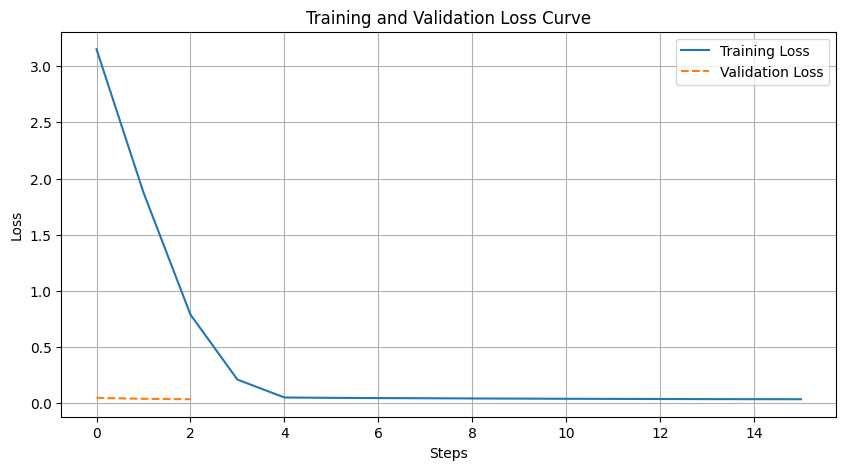

In [16]:
from model_utils import plot_loss_curves
plot_loss_curves(trainer)

# Save the model

In [18]:
trainer.save_model("../models/llama/llama-news-ft/llama2csp")

# Clean-up

In [18]:
from model_utils import clear_directory
import torch

torch.cuda.empty_cache()
del model, trainer, tokenizer, data_collator
clear_directory(logs_dir)

Directory does not exist: ../models/llama3.2-news-ft/logs/logs-c2osp


# Generate predictions

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mistral/Supervised_fine_tuning_(SFT)_of_an_LLM_using_Hugging_Face_tooling.ipynb

## Load saved model

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

saved_model = AutoModelForCausalLM.from_pretrained("../models/llama/llama-news-ft/llama2csp")
saved_tokenizer = AutoTokenizer.from_pretrained("../models/llama/llama-news-ft/llama2csp")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model = saved_model
tokenizer = saved_tokenizer

## Example

Set Stopping Criteria

In [47]:
from transformers import pipeline, StoppingCriteria, StoppingCriteriaList
import torch

class RefinedEndSentenceStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer, sentence_end_tokens):
        super().__init__()
        self.tokenizer = tokenizer
        self.sentence_end_token_ids = [
            self.tokenizer.convert_tokens_to_ids(token) for token in sentence_end_tokens
        ]
        self.eos_token_id = tokenizer.eos_token_id  # Include eos_token_id

    def is_valid_stop(self, input_ids):
        # Get the last token and the one before it
        if len(input_ids[0]) < 2:
            return False  # Not enough tokens to decide
        last_token_id = input_ids[0, -1].item()
        second_last_token_id = input_ids[0, -2].item()

        # Decode tokens to check context
        last_token = self.tokenizer.decode([last_token_id])
        second_last_token = self.tokenizer.decode([second_last_token_id])

        # Stop if it's a sentence-ending token and not part of an abbreviation
        if (
            last_token in [".", "!", "?"]  # Check if it's a sentence-ending token
            and len(second_last_token) > 1  # Ensure not part of an abbreviation
            and not second_last_token.isupper()  # Ensure it's not "U.S." or similar
        ):
            return True

        # Include end-of-sequence token
        return last_token_id == self.eos_token_id

    def __call__(self, input_ids, scores, **kwargs):
        return self.is_valid_stop(input_ids)


sentence_end_tokens = [".","\n","!", "?"]
stopping_criteria = StoppingCriteriaList([RefinedEndSentenceStoppingCriteria(tokenizer, sentence_end_tokens)])

In [50]:
from transformers import pipeline, StoppingCriteria, StoppingCriteriaList
import torch

class EndSentenceStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer, sentence_end_tokens):
        self.tokenizer = tokenizer
        self.sentence_end_tokens = sentence_end_tokens
        self.eos_token_id = tokenizer.eos_token_id

    def __call__(self, input_ids, scores, **kwargs):
        decoded_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return any(decoded_text.endswith(token) for token in self.sentence_end_tokens)

sentence_end_tokens = ["\n","!", "?"]
stopping_criteria = StoppingCriteriaList([EndSentenceStoppingCriteria(tokenizer, sentence_end_tokens)])

In [48]:
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        use_cache=True,
        device_map={'':torch.cuda.current_device()},
        max_new_tokens=32,
        min_length = 16,
        do_sample=False, # for greedy decoding
        temperature=None,
        top_p=None,
        return_full_text=False,
        no_repeat_ngram_size=3,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
        )

In [12]:
generator(formatted_test_dataset[2]['messages'],stopping_criteria=stopping_criteria)

[{'generated_text': ' It measures the water level.'}]

In [20]:
print("Context: ",formatted_test_dataset[5]['source_text'],end="\n\n")
print("Elaboration: ",formatted_test_dataset[5]['elaboration_sentence'] )

Context:  And his wife, Maria, was inspired to get her GED. The general educational development (GED) is equal to a high school diploma. Benito's path is more uncertain. He has not yet registered at the adult school. He and others like him are missing a key requirement " a high school diploma. And his wife, Maria, was inspired to get her GED. Benito's path is more uncertain. He has yet to register at the adult school.

Elaboration:  It is for adults who were unable to finish high school.


In [49]:
from tqdm.notebook import tqdm
import pandas as pd

df_results = pd.DataFrame({
    'source_text': dataset['test']['source_text'], 
    'elaboration_sentence': dataset['test']['elaboration_sentence'],
    'pred_elaboration': ""
})


for idx, row in tqdm(df_results.iterrows(),total=len(df_results)):
    input_text = f"{row['source_text']}"
    response = generator(input_text, stopping_criteria=stopping_criteria)
    df_results.at[idx,"pred_elaboration"] = response[0]["generated_text"]

  0%|          | 0/116 [00:00<?, ?it/s]

In [50]:
print("NaNs: ", len(df_results[df_results["pred_elaboration"]==""]))

NaNs:  0


In [25]:
df_results[df_results["pred_elaboration"]==""]

,source_text,elaboration_sentence,pred_elaboration


Fill NaNs

In [14]:
for idx, row in tqdm(df_results.iterrows(),total=len(df_results)):
    if row["pred_elaboration"]=="":
        input_text = f"Context: {row['source_text']}"
        response = generator(input_text, stopping_criteria=stopping_criteria)
        df_results.at[idx,"pred_elaboration"] = response[0]["generated_text"]

  0%|          | 0/116 [00:00<?, ?it/s]

## Save results

In [31]:
#from model_utils import remove_tags
import re
def postprocess(text):

    # removes all tag-like elements (e.g., <tag>) from the given text.
    if isinstance(text, str):
        text = re.sub(r'Context:', '', text).strip()
        return re.sub(r'<[^>]*>', '', text).strip()
        
    return text

df_results['pred_elaboration'] = df_results['pred_elaboration'].apply(postprocess)

In [51]:
df_results.head()

,source_text,elaboration_sentence,pred_elaboration
0,They did not need special skills or a college ...,Many do not have the money to get the training...,The problem is that the schools in New Haven ...
1,WASHINGTON – At least four people died in Midw...,A gauge is a kind of measuring stick.,The National Weather Service said the gauges ...
2,WASHINGTON – At least four people died in Midw...,It sits in the water.,The gauges measure the height of the water in...
3,Rescue crews swarmed into the ruins at Plaza T...,They raced against the setting sun to search t...,1.0.0\nRescue teams were able to reach the sch...
4,"One half of Istanbul lies in Europe, while the...",Turkey is larger than the state of Texas.,Istanbul is a city of contrasts.


In [52]:
df_results.to_csv("../data/gen_predictions/predictions_llama3.2-ft-instr-test_ds_c4s-masked.csv")

In [32]:
df_results.loc[1,"pred_elaboration"]

"user\nThe United States is in the midst of a debate about the future of the country's water infrastructure."